In [67]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
DATA_PROCESSED = Path("../data/processed")

DATA_PATH = DATA_PROCESSED /"gse183635_tep_tpm_labels.parquet"
TRAIN_PATH = DATA_PROCESSED / "gse183635_tep_tpm_train.parquet"
TEST_PATH  = DATA_PROCESSED / "gse183635_tep_tpm_test.parquet"

RANDOM_STATE = 42
TEST_SIZE = 0.2  

In [ ]:
df = pd.read_parquet(DATA_PATH)

if "Sample ID" in df.columns:
    df = df.set_index("Sample ID", drop=False)

metadata_cols = [
    "Sample ID",
    "Patient_group",
    "Stage",
    "Sex",
    "Age",
    "Sample-supplying institution",
    "Training series",
    "Evaluation series",
    "Validation series",
    "lib.size",
    "classificationScoreCancer",
    "Class_group",
]

gene_cols = [c for c in df.columns if c not in metadata_cols]

X_all = df[gene_cols]        # matriz de expresión 
meta_all = df[metadata_cols] # metadatos


# EDA poblacional básico

## Tamaños y clases

In [7]:
print("N muestras:", len(df))
print("\nDistribución por Class_group")
print(meta_all["Class_group"].value_counts(dropna=False))

print("\nDistribución por Patient_group")
print(meta_all["Patient_group"].value_counts(dropna=False))

N muestras: 2351

Distribución por Class_group
Class_group
Malignant       1628
nonMalignant     723
Name: count, dtype: int64

Distribución por Patient_group
Patient_group
Non-small-cell lung cancer        522
Asymptomatic controls             390
Ovarian cancer                    144
Glioma                            132
Pancreatic cancer                 126
Head and neck cancer              101
Breast cancer                      93
Multiple sclerosis                 86
Cholangiocarcinoma                 85
Colorectal cancer                  85
Pulmonary Hypertension             72
Melanoma                           68
Sarcoma                            53
Pancreatic diseases                50
Medically-intractable epilepsy     44
Endometrial cancer                 39
Prostate cancer                    35
Multiple Myeloma                   31
Renal cell cancer                  28
Urothelial cancer                  28
Former sarcoma                     26
Angina pectoris              

In [8]:
print("\nDistribución por Stage")
print(meta_all["Stage"].value_counts(dropna=False))



Distribución por Stage
Stage
n.a.    978
IV      861
III     235
II      166
I       111
Name: count, dtype: int64


## Edad, sexo, institución

In [12]:
print("\nResumen edad")
print(meta_all["Age"].describe())

print("\nDistribución por Sex")
print(meta_all["Sex"].value_counts(dropna=False))


Resumen edad
count    2328.000000
mean       58.490550
std        14.137847
min        18.000000
25%        51.000000
50%        61.000000
75%        69.000000
max        92.000000
Name: Age, dtype: float64

Distribución por Sex
Sex
F       1220
M       1111
n.a.      20
Name: count, dtype: int64


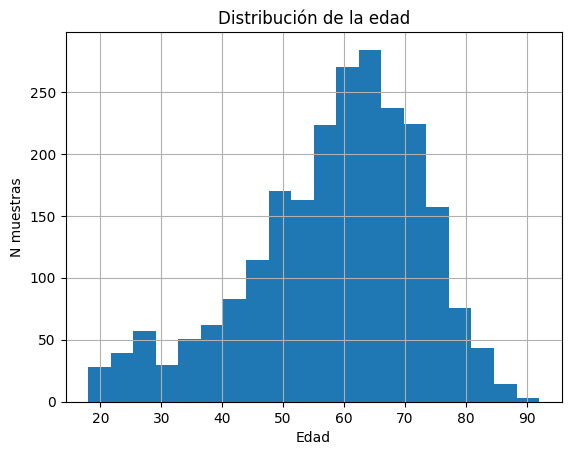

In [19]:
meta_all["Age"].hist(bins=20)
plt.xlabel("Edad")
plt.ylabel("N muestras")
plt.title("Distribución de la edad")
plt.grid(True)
plt.show()


# Split train/test estratificado

In [ ]:
y_all = meta_all["Class_group"]

train_idx, test_idx = train_test_split(
    df.index,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_all # balanceado
)

print("Train:", len(train_idx), "Test:", len(test_idx))


Train: 1880 Test: 471


In [ ]:
df_train = df.loc[train_idx].copy()
df_test  = df.loc[test_idx].copy()


df_train.to_parquet(TRAIN_PATH, index=False)
df_test.to_parquet(TEST_PATH, index=False)

# Guardar solo los IDs para trazabilidad
REF_PATH = DATA_PROCESSED / "gse183635_split_indices.csv"
pd.DataFrame({
    "Sample ID": df.index,
    "split": np.where(df.index.isin(train_idx), "train", "test")
}).to_csv(REF_PATH, index=False)


# Estudio de heterogeneidad en nonMalignant

In [ ]:
df_train = pd.read_parquet(TRAIN_PATH)
df_train = df_train.set_index("Sample ID", drop=False)

meta_train = df_train[metadata_cols].copy()
gene_cols = [c for c in df_train.columns if c not in metadata_cols]
X_train = df_train[gene_cols]

mask_nonmal = meta_train["Class_group"] == "nonMalignant"
X_nm = X_train[mask_nonmal]
meta_nm = meta_train[mask_nonmal]

print("N nonMalignant en train:", X_nm.shape)

N nonMalignant en train: (578, 5440)


In [ ]:
# Filtrar genes con muy baja varianza
var = X_nm.var(axis=0)

var_threshold = np.percentile(var, 10)
high_var_genes = var[var > var_threshold].index

X_nm_hv = X_nm[high_var_genes]

X_nm_log = np.log1p(X_nm_hv)

scaler = StandardScaler()
X_nm_scaled = scaler.fit_transform(X_nm_log)

## PCA


Número de componentes para >= 95% de varianza: 352
Varianza explicada acumulada real con 352 PCs: 0.9502237261170781


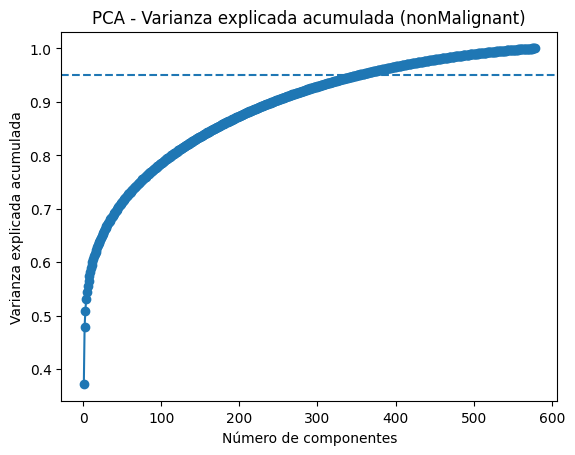

In [55]:
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_nm_scaled)

var_ratio = pca_full.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)

threshold = 0.95
n_components = int(np.searchsorted(cum_var_ratio, threshold) + 1)

print(f"\nNúmero de componentes para >= {threshold*100:.0f}% de varianza:",
      n_components)
print(f"Varianza explicada acumulada real con {n_components} PCs:",
      cum_var_ratio[n_components - 1])

plt.figure()
plt.plot(range(1, len(cum_var_ratio) + 1), cum_var_ratio, marker="o")
plt.axhline(threshold, linestyle="--")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("PCA - Varianza explicada acumulada (nonMalignant)")
plt.show()

In [56]:
pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_nm_scaled)

print("Shape de X_pca:", X_pca.shape)

Shape de X_pca: (578, 352)
